In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
import matplotlib.pyplot as plt
import os
import random

In [2]:
# Define dataset paths
DATASET_DIR = "C:\\Users\\Shweta\\tomatoDisease\\training\\dataset"
TRAIN_DIR = os.path.join(DATASET_DIR, "train")
VAL_DIR = os.path.join(DATASET_DIR, "val")

# Define image size and batch size
IMAGE_SIZE = (256, 256)
BATCH_SIZE = 32



In [5]:
# Load datasets

train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    seed=123,
    image_size=(256, 256),
    batch_size=32
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    VAL_DIR,
    seed=123,
    image_size=(256, 256),
    batch_size=32
)
#  Check the dataset
for images, labels in train_ds.take(1):
    print(f"Image batch shape: {images.shape}")
    print(f"Label batch shape: {labels.shape}")


Found 10000 files belonging to 10 classes.
Found 1000 files belonging to 10 classes.
Image batch shape: (32, 256, 256, 3)
Label batch shape: (32,)


In [6]:

# Extract class names before modifying the dataset
class_names = train_ds.class_names
num_classes = len(class_names)  # Number of classes

print("Class Names:", class_names)



Class Names: ['Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Tomato_mosaic_virus', 'Tomato___healthy']


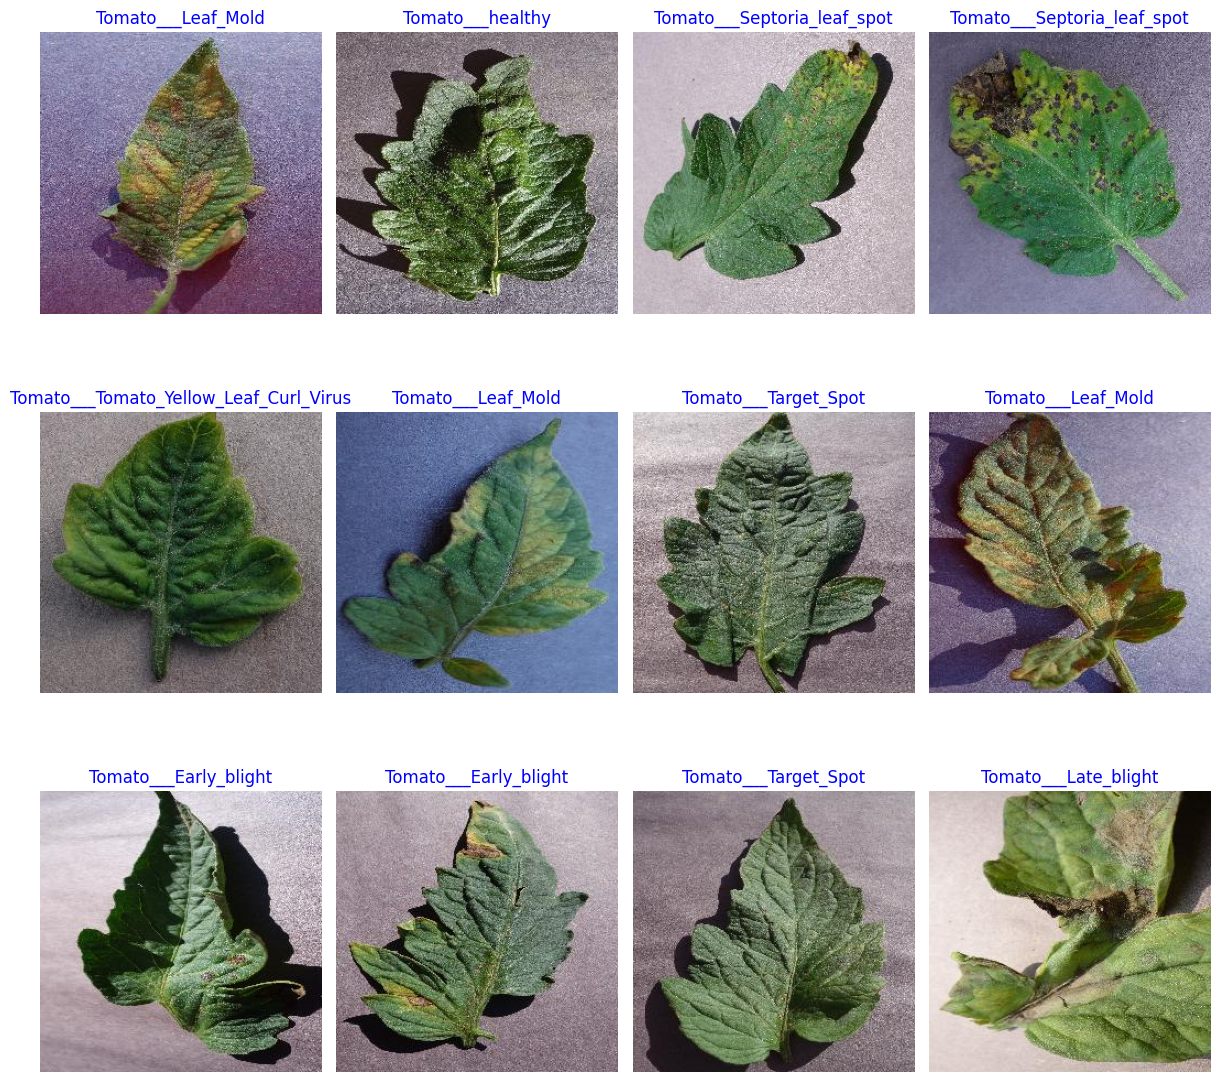

In [7]:
import os
import random
import matplotlib.pyplot as plt
from matplotlib.image import imread

# Define dataset path
dataset_path = "C:\\Users\\Shweta\\tomatoDisease\\training\\dataset"

# Collect all image paths from 'train' and 'val' folders
image_paths = []
for folder in ['train', 'val']:
    folder_path = os.path.join(dataset_path, folder)
    for class_folder in os.listdir(folder_path):
        class_path = os.path.join(folder_path, class_folder)
        if os.path.isdir(class_path):
            image_paths += [os.path.join(class_path, img) for img in os.listdir(class_path)]

# Plot 12 random images with labels
plt.figure(figsize=(12, 12))
for i in range(1, 13):
    plt.subplot(3, 4, i)  # Use 3 rows and 4 columns for 12 images
    rand_img_path = random.choice(image_paths)
    rand_img = imread(rand_img_path)
    
    # Extract class name from the path
    class_name = os.path.basename(os.path.dirname(rand_img_path))
    
    plt.imshow(rand_img)
    plt.axis('off')  # Hide axis values
    plt.title(class_name, fontsize=12, color='blue')  # Add class label
    plt.xlabel(f'Width: {rand_img.shape[1]}', fontsize=10)
    plt.ylabel(f'Height: {rand_img.shape[0]}', fontsize=10)

# Adjust layout after plotting
plt.tight_layout()
plt.show()

In [8]:
AUTOTUNE = tf.data.AUTOTUNE

# Normalize pixel values to [0,1]
train_ds = train_ds.map(lambda x, y: (x / 255.0, y), num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(lambda x, y: (x / 255.0, y), num_parallel_calls=AUTOTUNE)

# Optimize dataset loading
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [11]:
from tensorflow import keras
from tensorflow.keras import layers

# Data Augmentation
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomBrightness(0.2),
])

def augment(image, label):
    return data_augmentation(image), label


In [35]:
import os
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import numpy as np

# Define dataset paths
DATASET_DIR = "C:\\Users\\Shweta\\tomatoDisease\\training\\dataset"
TRAIN_DIR = os.path.join(DATASET_DIR, "train")
VAL_DIR = os.path.join(DATASET_DIR, "val")

# Define image size and batch size
IMAGE_SIZE = (128, 128)  # Reduced image size for faster training
BATCH_SIZE = 16  # Reduced batch size for better memory usage

# Build the CNN model
model = models.Sequential([
    layers.Input(shape=(*IMAGE_SIZE, 3)),  # Input layer
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),  # First Conv layer
    layers.BatchNormalization(),  # Batch normalization for stability
    layers.MaxPooling2D(2, 2),  # Max pooling to reduce spatial dimensions

    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),  # Second Conv layer
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),  # Third Conv layer
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, 2),

    layers.GlobalAveragePooling2D(),  # Global average pooling to reduce parameters

    layers.Dense(128, activation='relu', kernel_regularizer='l2'),  # Fully connected layer with L2 regularization
    layers.Dropout(0.6),  # Increased dropout rate to prevent overfitting
    layers.Dense(10, activation='softmax')  # Output layer for 10 classes
])

# Compile the model
model.compile(
    optimizer='adam',  # Adam optimizer
    loss='sparse_categorical_crossentropy',  # Loss function for integer labels
    metrics=['accuracy']  # Monitor accuracy
)

# Print model summary
model.summary()

# Create ImageDataGenerators for training and validation
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values
    rotation_range=40,  # Random rotations
    width_shift_range=0.3,  # Random horizontal shifts
    height_shift_range=0.3,  # Random vertical shifts
    shear_range=0.3,  # Random shearing
    zoom_range=0.3,  # Random zooming
    horizontal_flip=True,  # Random horizontal flips
    vertical_flip=True,  # Random vertical flips
    brightness_range=[0.8, 1.2],  # Random brightness adjustments
    fill_mode='nearest'  # Fill missing pixels after transformations
)

val_datagen = ImageDataGenerator(rescale=1./255)  # Only rescale for validation data

# Load training and validation data using flow_from_directory
train_data = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMAGE_SIZE,  # Resize images to the desired size
    batch_size=BATCH_SIZE,
    class_mode='sparse',  # For integer labels
    shuffle=True  # Shuffle the training data
)

val_data = val_datagen.flow_from_directory(
    VAL_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='sparse',  # For integer labels
    shuffle=False  # No need to shuffle validation data
)

# Early Stopping callback to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=10,  # Increased patience to 10 epochs
    restore_best_weights=True  # Restore the best model weights
)

# Learning Rate Scheduler callback
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  # Monitor validation loss
    factor=0.2,  # Reduce learning rate by a factor of 0.2
    patience=3,  # Wait for 3 epochs before reducing LR
    min_lr=1e-6  # Minimum learning rate
)



Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_29 (Conv2D)                   │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_23               │ (None, 128, 128, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_29 (MaxPooling2D)      │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_30 (Conv2D)                   │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_24               │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_30 (MaxPooling2D)      │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_31 (Conv2D)                   │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_25               │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_31 (MaxPooling2D)      │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_8           │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 111,946 (437.29 KB)

 Trainable params: 111,498 (435.54 KB)

 Non-trainable params: 448 (1.75 KB)

Found 10000 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.


In [36]:
# Train the model
history = model.fit(
    train_data,
    epochs=50,  # Number of epochs
    validation_data=val_data,
    callbacks=[early_stopping, reduce_lr]  # Add callbacks
)


Epoch 1/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 198s 311ms/step - accuracy: 0.4290 - loss: 2.5572 - val_accuracy: 0.3360 - val_loss: 2.5464 - learning_rate: 0.0010
Epoch 2/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 192s 307ms/step - accuracy: 0.6432 - loss: 1.2834 - val_accuracy: 0.3350 - val_loss: 2.6147 - learning_rate: 0.0010
Epoch 3/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 193s 308ms/step - accuracy: 0.7044 - loss: 1.0205 - val_accuracy: 0.4530 - val_loss: 1.8709 - learning_rate: 0.0010
Epoch 4/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 195s 311ms/step - accuracy: 0.7309 - loss: 0.9296 - val_accuracy: 0.6120 - val_loss: 1.4623 - learning_rate: 0.0010
Epoch 5/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 193s 309ms/step - accuracy: 0.7802 - loss: 0.7871 - val_accuracy: 0.8400 - val_loss: 0.5948 - learning_rate: 0.0010
Epoch 6/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 196s 314ms/step - accuracy: 0.7977 - loss: 0.7327 - val_accuracy: 0.5310 - val_loss: 2.0877 - learning_rate: 0.0010
Epoch 7/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 210s 336ms/step - accura

In [37]:
import os
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import numpy as np

# Define dataset paths
DATASET_DIR = "C:\\Users\\Shweta\\tomatoDisease\\training\\dataset"
TRAIN_DIR = os.path.join(DATASET_DIR, "train")
VAL_DIR = os.path.join(DATASET_DIR, "val")

# Define image size and batch size
IMAGE_SIZE = (128, 128)  # Reduced image size for faster training
BATCH_SIZE = 16  # Reduced batch size for better memory usage

# Build the CNN model
model = models.Sequential([
    layers.Input(shape=(*IMAGE_SIZE, 3)),  # Input layer
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),  # First Conv layer
    layers.BatchNormalization(),  # Batch normalization for stability
    layers.MaxPooling2D(2, 2),  # Max pooling to reduce spatial dimensions

    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),  # Second Conv layer
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),  # Third Conv layer
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, 2),

    layers.GlobalAveragePooling2D(),  # Global average pooling to reduce parameters

    layers.Dense(128, activation='relu', kernel_regularizer='l2'),  # Fully connected layer with L2 regularization
    layers.Dropout(0.7),  # Increased dropout rate to prevent overfitting
    layers.Dense(10, activation='softmax')  # Output layer for 10 classes
])

# Compile the model
model.compile(
    optimizer='adam',  # Adam optimizer
    loss='sparse_categorical_crossentropy',  # Loss function for integer labels
    metrics=['accuracy']  # Monitor accuracy
)

# Print model summary
model.summary()

# Create ImageDataGenerators for training and validation
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values
    rotation_range=40,  # Random rotations
    width_shift_range=0.3,  # Random horizontal shifts
    height_shift_range=0.3,  # Random vertical shifts
    shear_range=0.3,  # Random shearing
    zoom_range=0.3,  # Random zooming
    horizontal_flip=True,  # Random horizontal flips
    vertical_flip=True,  # Random vertical flips
    brightness_range=[0.8, 1.2],  # Random brightness adjustments
    fill_mode='nearest'  # Fill missing pixels after transformations
)

val_datagen = ImageDataGenerator(rescale=1./255)  # Only rescale for validation data

# Load training and validation data using flow_from_directory
train_data = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMAGE_SIZE,  # Resize images to the desired size
    batch_size=BATCH_SIZE,
    class_mode='sparse',  # For integer labels
    shuffle=True  # Shuffle the training data
)

val_data = val_datagen.flow_from_directory(
    VAL_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='sparse',  # For integer labels
    shuffle=False  # No need to shuffle validation data
)

# Early Stopping callback to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=15,  # Increased patience to 15 epochs
    restore_best_weights=True  # Restore the best model weights
)

# Learning Rate Scheduler callback
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  # Monitor validation loss
    factor=0.2,  # Reduce learning rate by a factor of 0.2
    patience=5,  # Wait for 5 epochs before reducing LR
    min_lr=1e-6  # Minimum learning rate
)



Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_32 (Conv2D)                   │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_26               │ (None, 128, 128, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_32 (MaxPooling2D)      │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_33 (Conv2D)                   │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_27               │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_33 (MaxPooling2D)      │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_34 (Conv2D)                   │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_28               │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_34 (MaxPooling2D)      │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_9           │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 111,946 (437.29 KB)

 Trainable params: 111,498 (435.54 KB)

 Non-trainable params: 448 (1.75 KB)

Found 10000 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.


In [38]:
# Train the model
history = model.fit(
    train_data,
    epochs=50,  # Number of epochs
    validation_data=val_data,
    callbacks=[early_stopping, reduce_lr]  # Add callbacks
)

Epoch 1/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 180s 280ms/step - accuracy: 0.3865 - loss: 2.7003 - val_accuracy: 0.1190 - val_loss: 7.3126 - learning_rate: 0.0010
Epoch 2/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 195s 312ms/step - accuracy: 0.6293 - loss: 1.3697 - val_accuracy: 0.6510 - val_loss: 1.0969 - learning_rate: 0.0010
Epoch 3/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 200s 320ms/step - accuracy: 0.6807 - loss: 1.1003 - val_accuracy: 0.3000 - val_loss: 3.4114 - learning_rate: 0.0010
Epoch 4/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 196s 313ms/step - accuracy: 0.7180 - loss: 0.9712 - val_accuracy: 0.6430 - val_loss: 1.2044 - learning_rate: 0.0010
Epoch 5/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 197s 315ms/step - accuracy: 0.7656 - loss: 0.8344 - val_accuracy: 0.6870 - val_loss: 1.2813 - learning_rate: 0.0010
Epoch 6/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 197s 316ms/step - accuracy: 0.7834 - loss: 0.7827 - val_accuracy: 0.3980 - val_loss: 3.0583 - learning_rate: 0.0010
Epoch 7/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 196s 313ms/step - accura

In [44]:
# Evaluate the model on validation data
val_loss, val_accuracy = model.evaluate(val_data)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Evaluate the model on test data (if available)
train_loss, train_accuracy = model.evaluate(train_data)
print(f"Train Loss: {train_loss}")
print(f"Train Accuracy: {train_accuracy}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - accuracy: 0.9715 - loss: 0.1419
Validation Loss: 0.16617432236671448
Validation Accuracy: 0.9620000123977661
625/625 ━━━━━━━━━━━━━━━━━━━━ 121s 194ms/step - accuracy: 0.9832 - loss: 0.1156
Train Loss: 0.11701571196317673
Train Accuracy: 0.9815000295639038


In [42]:
# Save the trained model
model.save("bestModel.keras")


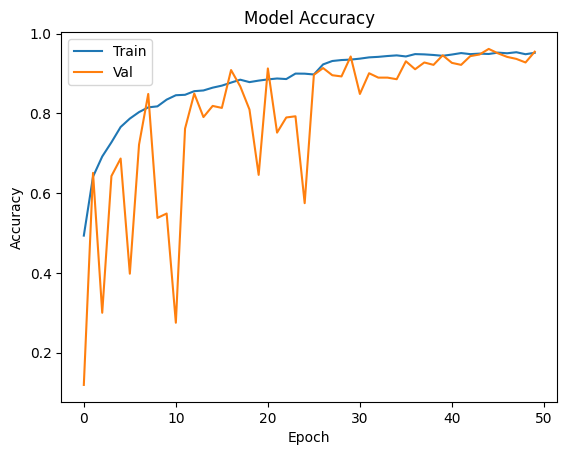

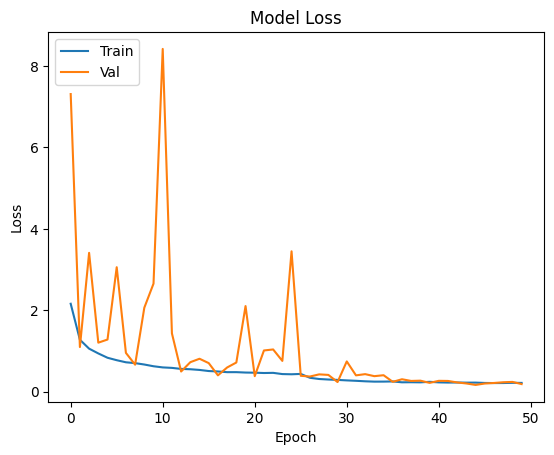

In [43]:
# Visualize training progress
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Plot training & validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [51]:
# Import necessary modules
from tensorflow.keras.preprocessing import image
import numpy as np

# Make predictions on a new image
img_path = "C:\\Users\\Shweta\\tomatoDisease\\training\\test_image.JPG"  # Replace with the path to your image
img = image.load_img(img_path, target_size=IMAGE_SIZE)  # Load and resize the image
img_array = image.img_to_array(img)  # Convert the image to a numpy array
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array /= 255.0  # Normalize the image

# Make a prediction
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions, axis=1)  # Get the predicted class

# Map the predicted class index to the class name
class_names = list(train_data.class_indices.keys())
predicted_class_name = class_names[predicted_class[0]]

print(f"Predicted Class: {predicted_class_name}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Predicted Class: Tomato___healthy


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


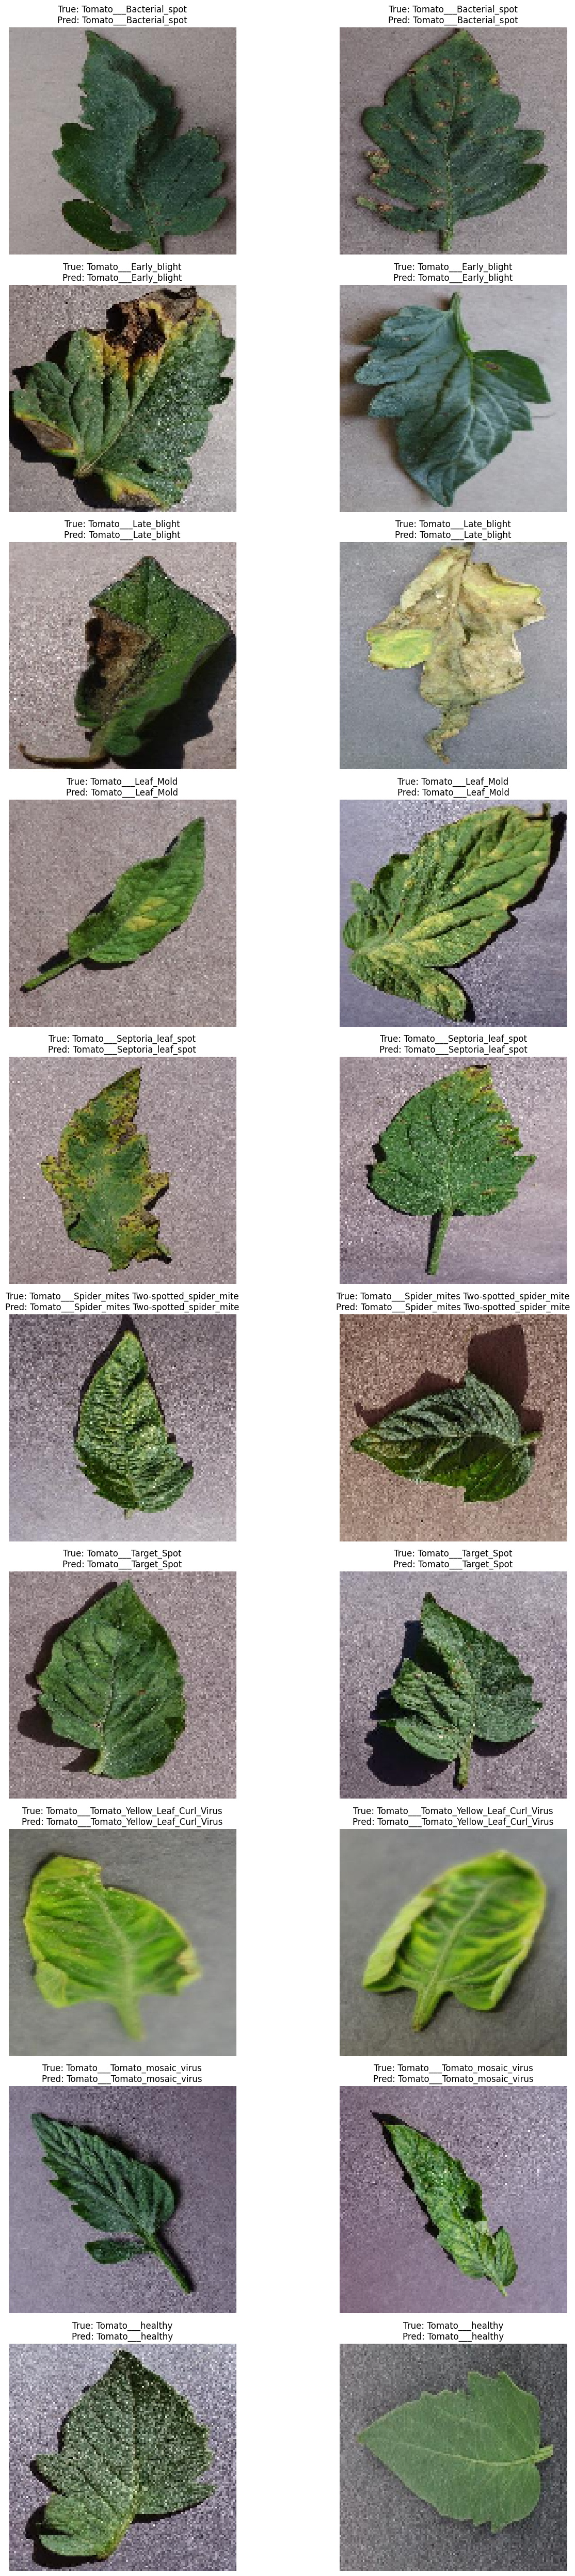

In [54]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import numpy as np

# Get class names from the training data
class_names = list(train_data.class_indices.keys())

# Number of images to visualize per class
num_images_per_class = 2  # Adjust as needed

# Create a figure to display the images
plt.figure(figsize=(15, 5 * len(class_names)))  # Adjust figure size based on the number of classes

# Iterate through each class
for class_idx, class_name in enumerate(class_names):
    # Find indices of images belonging to the current class
    class_indices = np.where(val_data.classes == class_idx)[0]
    
    # Randomly select `num_images_per_class` images from the current class
    selected_indices = np.random.choice(class_indices, size=num_images_per_class, replace=False)
    
    # Plot the selected images
    for i, idx in enumerate(selected_indices):
        plt.subplot(len(class_names), num_images_per_class, class_idx * num_images_per_class + i + 1)
        img = image.load_img(val_data.filepaths[idx], target_size=IMAGE_SIZE)  # Load image
        plt.imshow(img)
        
        # Prepare the image for prediction
        img_array = image.img_to_array(img) / 255.0  # Normalize the image
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
        
        # Make a prediction
        prediction = model.predict(img_array)
        predicted_class = np.argmax(prediction, axis=1)[0]  # Get the predicted class index
        
        # Set the title with true and predicted labels
        plt.title(f"True: {class_names[val_data.classes[idx]]}\nPred: {class_names[predicted_class]}")
        plt.axis('off')

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()